In [35]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from vqVAE import VQVAE

from matplotlib.colors import ListedColormap

In [84]:
def reconstruct_logits(batch, model):
    output, _, _, _ = model(batch.float())
    return output



def visualize_batch(batch, title):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)

    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray', vmin=0, vmax=1)
        axes[i,1].imshow(img[1,:,:], cmap = 'gray', vmin=0, vmax=1)
        axes[i,2].imshow(img[2,:,:], cmap = 'gray', vmin=0, vmax=1)
        axes[i,3].imshow(img[3,:,:], cmap = 'gray', vmin=0, vmax=1)
        # axes[i].axis('off')

    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def visualize_batch_logits(batch, title):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)

    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def visualize_errors(true_segs, pred_segs, title):
    # batch_size = batch.shape[0]
    samples = 8

    custom_colors = [
    '#000000', '#ff0000', '#ffd700', '#00ffff']
    cmap = ListedColormap(custom_colors)
    # error_cmap = LinearSegmentedColormap.from_list('black_red', ['black', 'red'], N=256)

    error_mask = torch.where(true_segs != pred_seg, 1, 0)

    fig, axes = plt.subplots(samples, 3, figsize=(8, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)


    for i in range(samples):
        axes[i,0].imshow(true_seg[i], cmap = cmap)
        axes[i,0].axis('off')

        axes[i,1].imshow(pred_segs[i], cmap = cmap)
        axes[i,1].axis('off')

        axes[i,2].imshow(error_mask[i], cmap = 'magma')
        axes[i,2].axis('off')

    row_titles = ['Ground truth', 'Vq-Vae predictions', 'Pixel Errors']
    for i in range(3):
        axes[0, i].set_title(row_titles[i], fontsize=14, fontweight='bold')
    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [3]:

L = 128 # image size L=W
BATCH_SIZE = 16



In [4]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")

test_dataset  = load_dataset(test_set_path)




NiftiImageIO (0x3b855740): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3b855740): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3bb1dd30): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame11_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3bb1dd30): /home/ids/ihamdaoui-21/ACDC/database/testing/patient103/patient103_frame11_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3b8dde60): /home/ids/ihamdaoui-21/ACDC/database/testing/patient109/patient109_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3b8dde60): /home/ids/ihamdaoui-21/ACDC/database/testing/patient109/patient109_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3b963fc0): /home/ids/ihamdaoui-21/ACDC/database/testing/patient109/patient109_frame10_gt.nii.gz has unexpected scales in

In [5]:
input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

In [6]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 


In [7]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


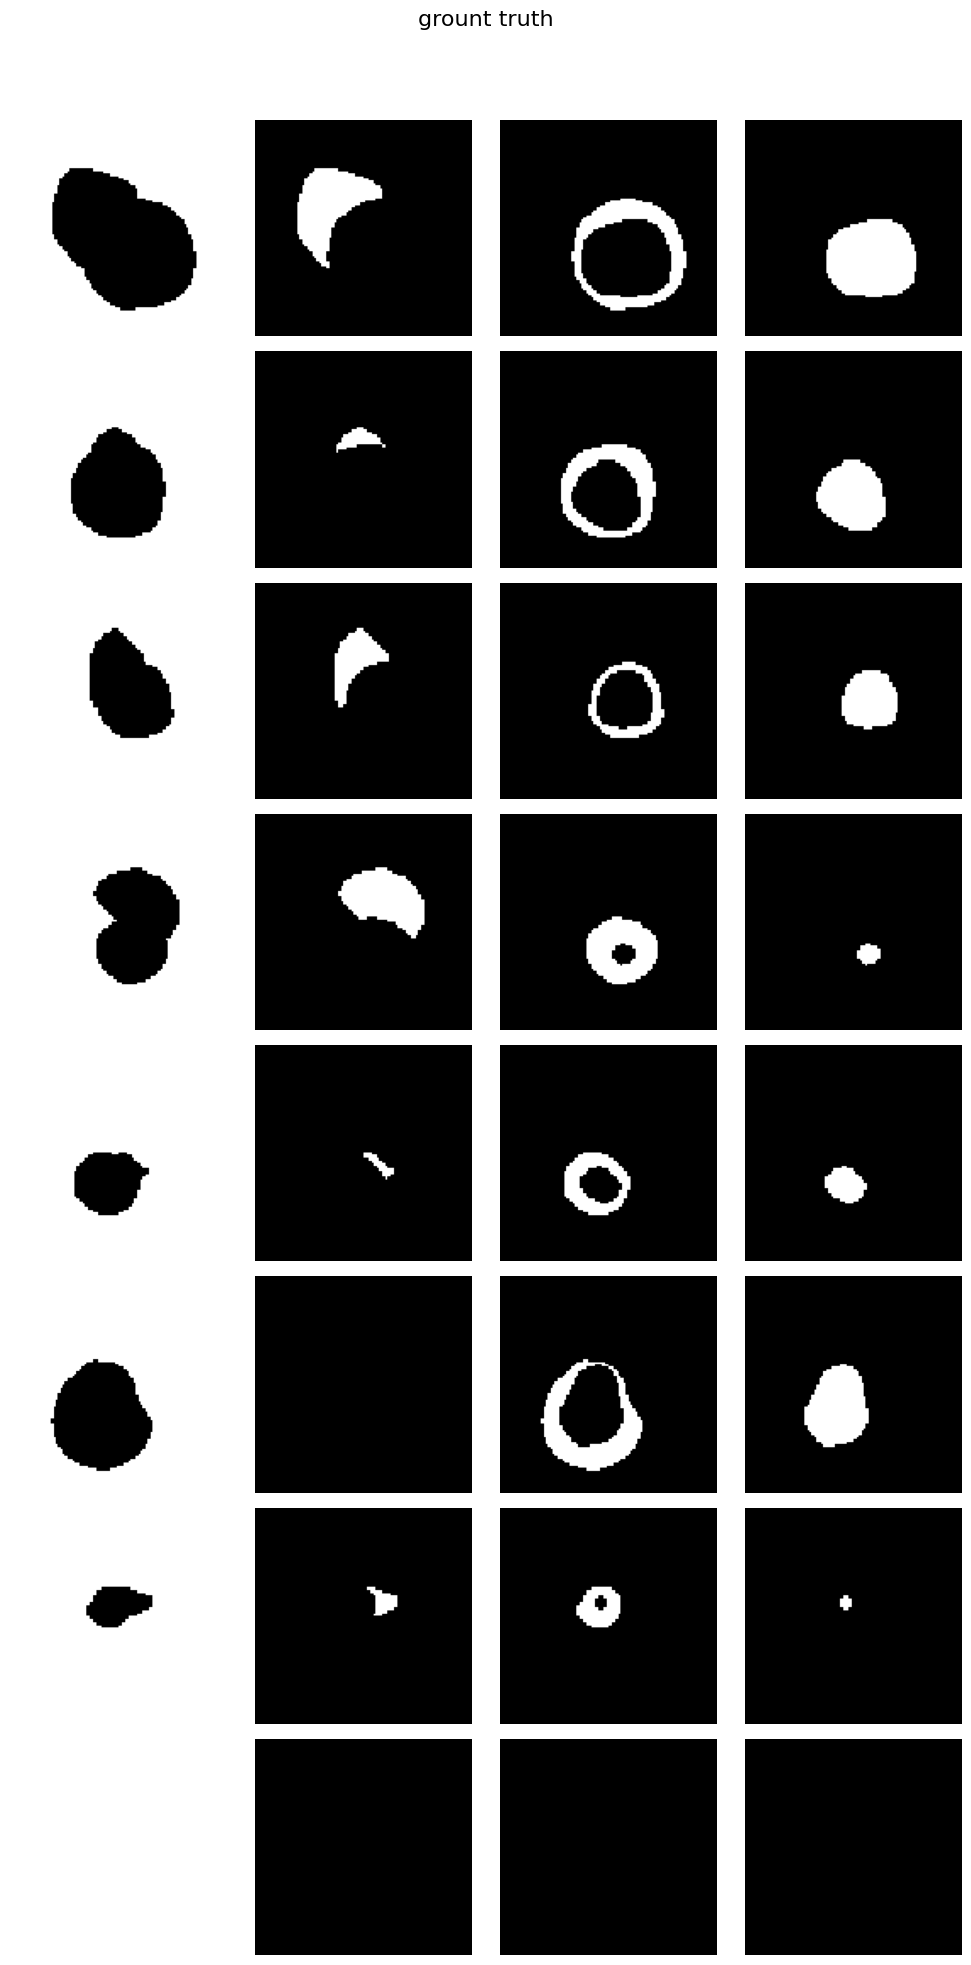

In [8]:
vis_batch = next(iter(TestLoader)).to(device)
visualize_batch(vis_batch.detach().cpu(), title= "grount truth")

In [9]:
model_path = 'saved_models/vqvae_100_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_240326/1315759818.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


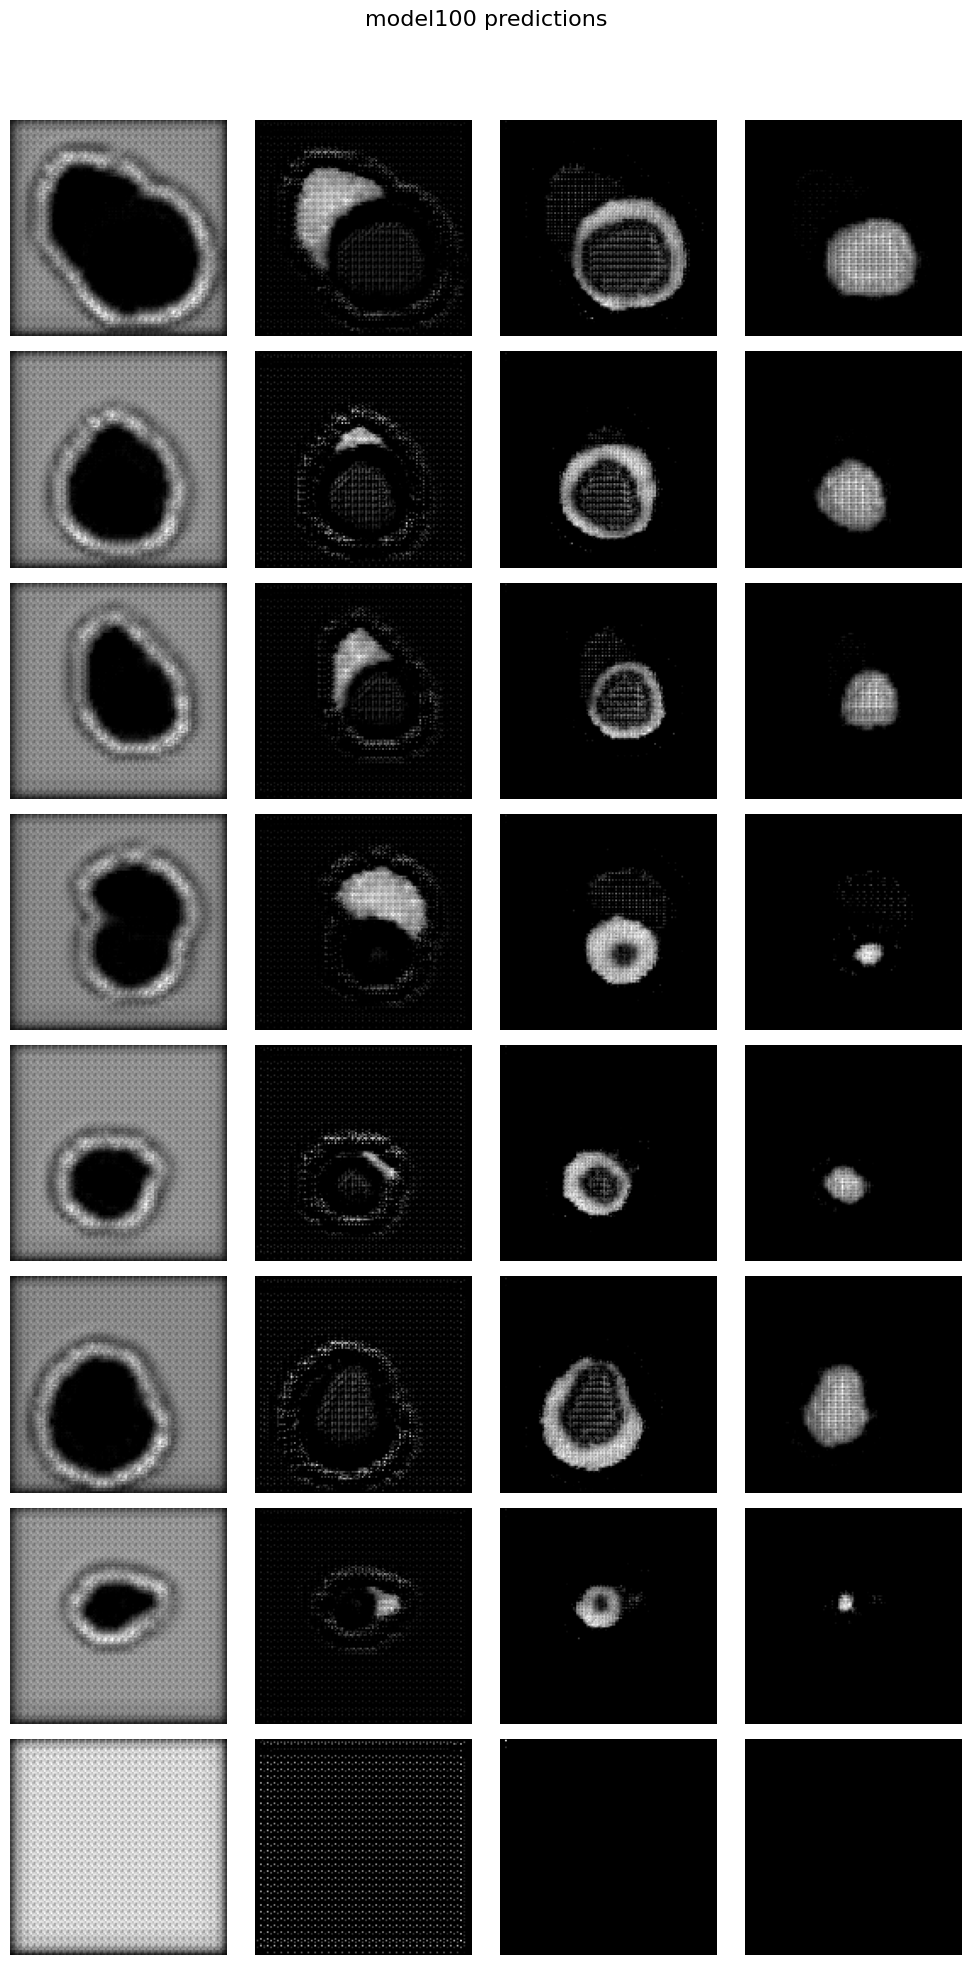

In [16]:

batch_hat = reconstruct_logits(vis_batch, model)
visualize_batch_logits( batch_hat.detach().cpu() , title= "model100 predictions")

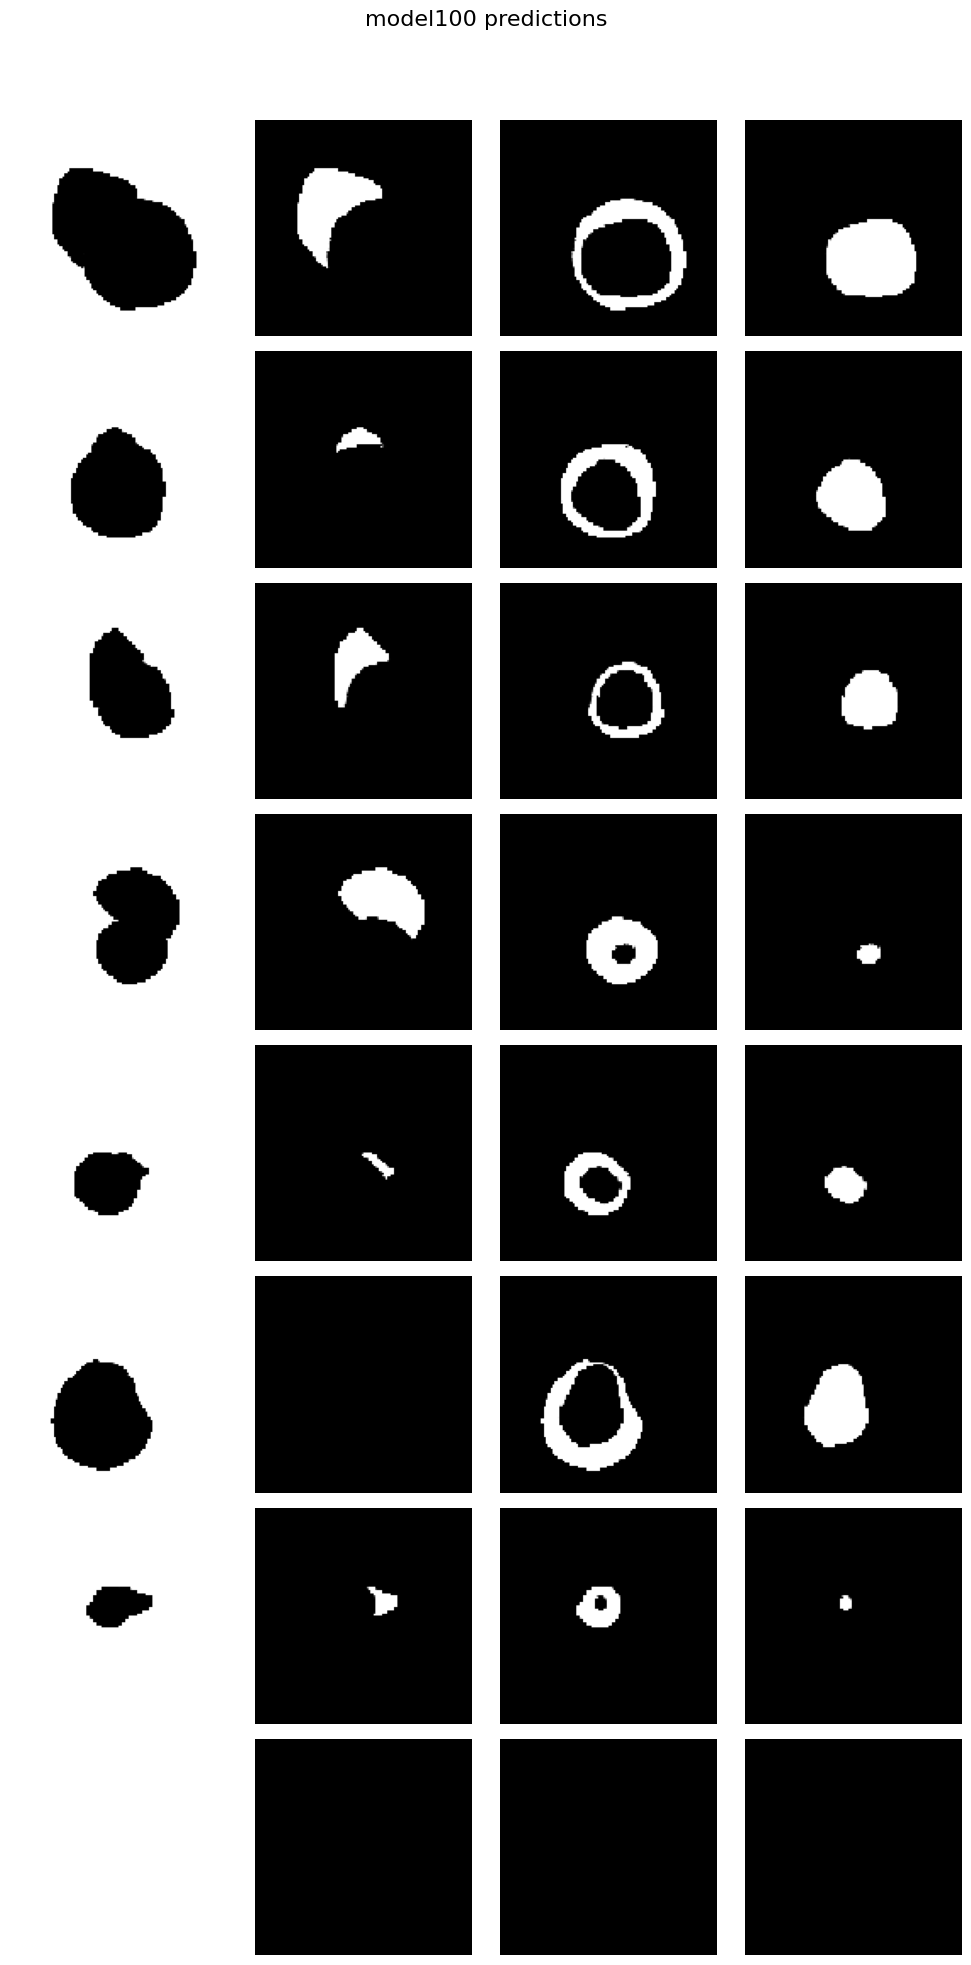

In [12]:
probs = F.softmax(batch_hat, dim=1) 
visualize_batch( probs.detach().cpu() , title= "model100 predictions")

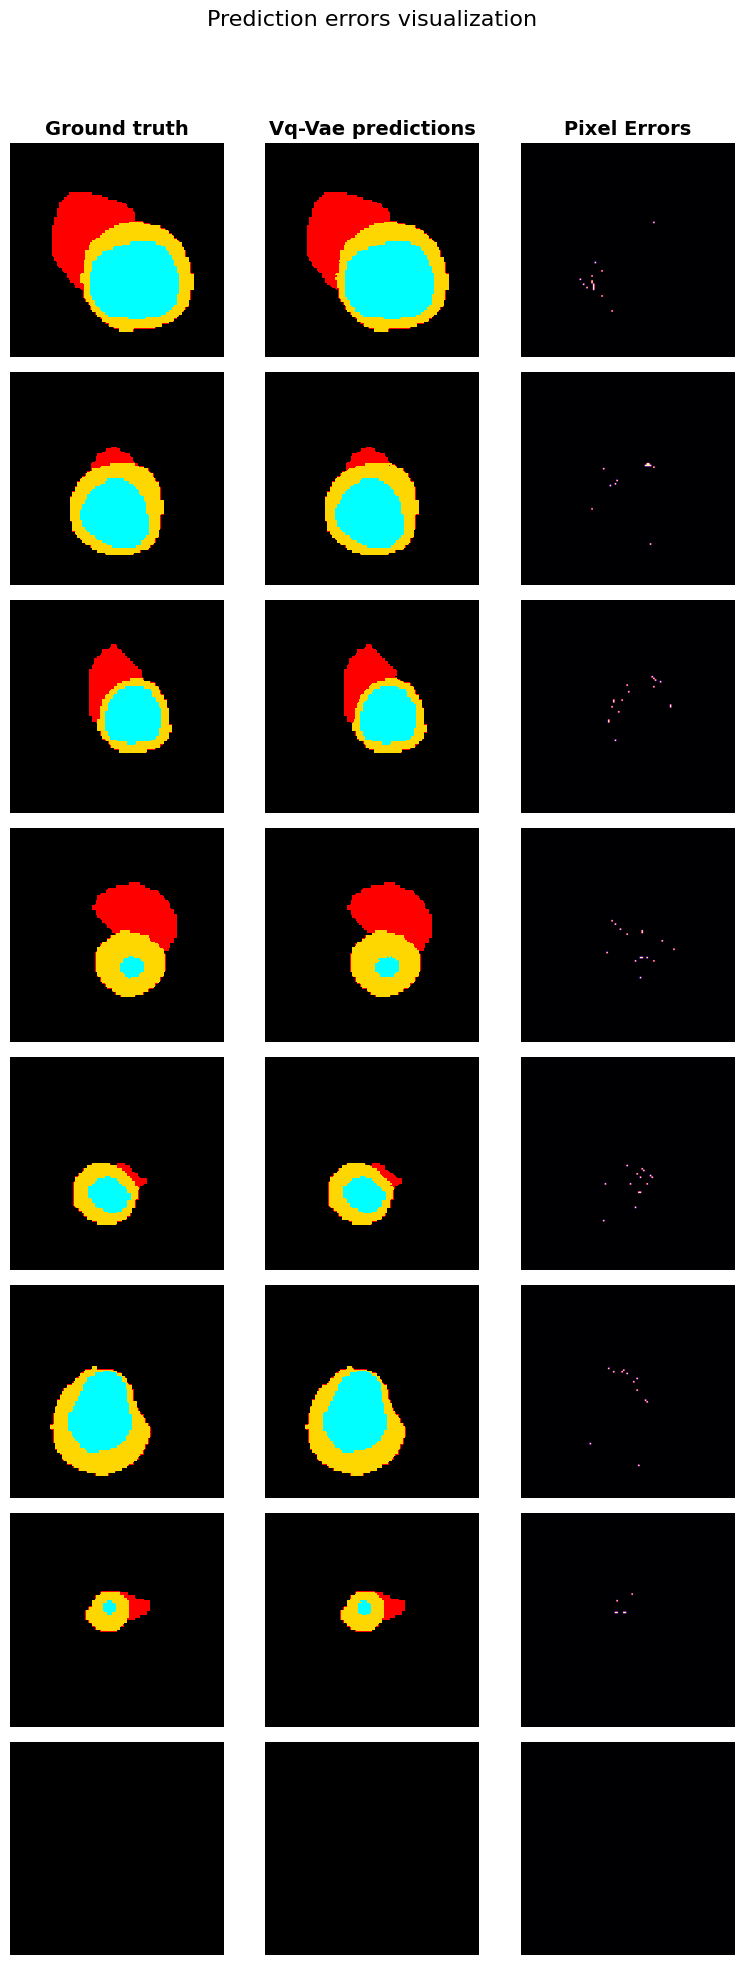

In [ ]:

pred_seg = torch.argmax(probs,     dim=1).detach().cpu()
true_seg = torch.argmax(vis_batch, dim=1).detach().cpu()

visualize_errors(true_seg, pred_seg, 'Prediction errors visualization')


----------

In [85]:
model_path = 'saved_models/vqvae_101_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_240326/3876531679.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


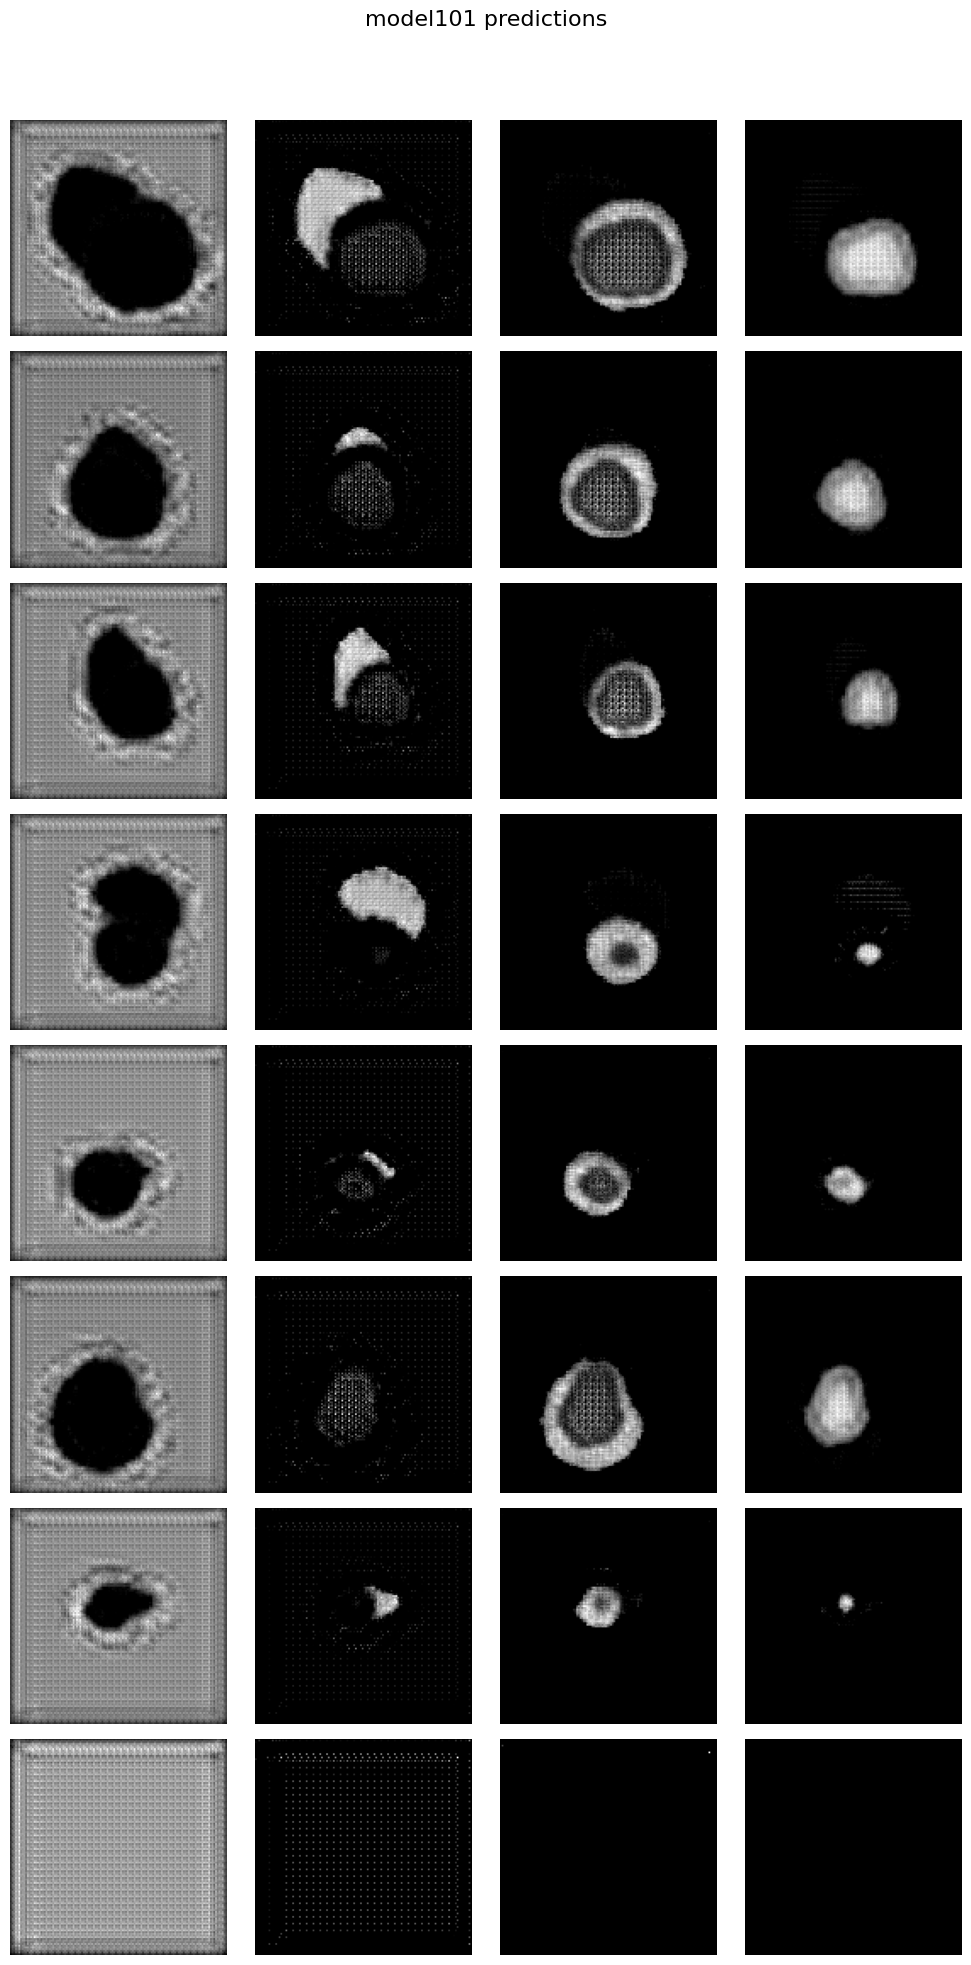

In [86]:

batch_hat = reconstruct_logits(vis_batch, model)
visualize_batch_logits( batch_hat.detach().cpu() , title= "model101 predictions")


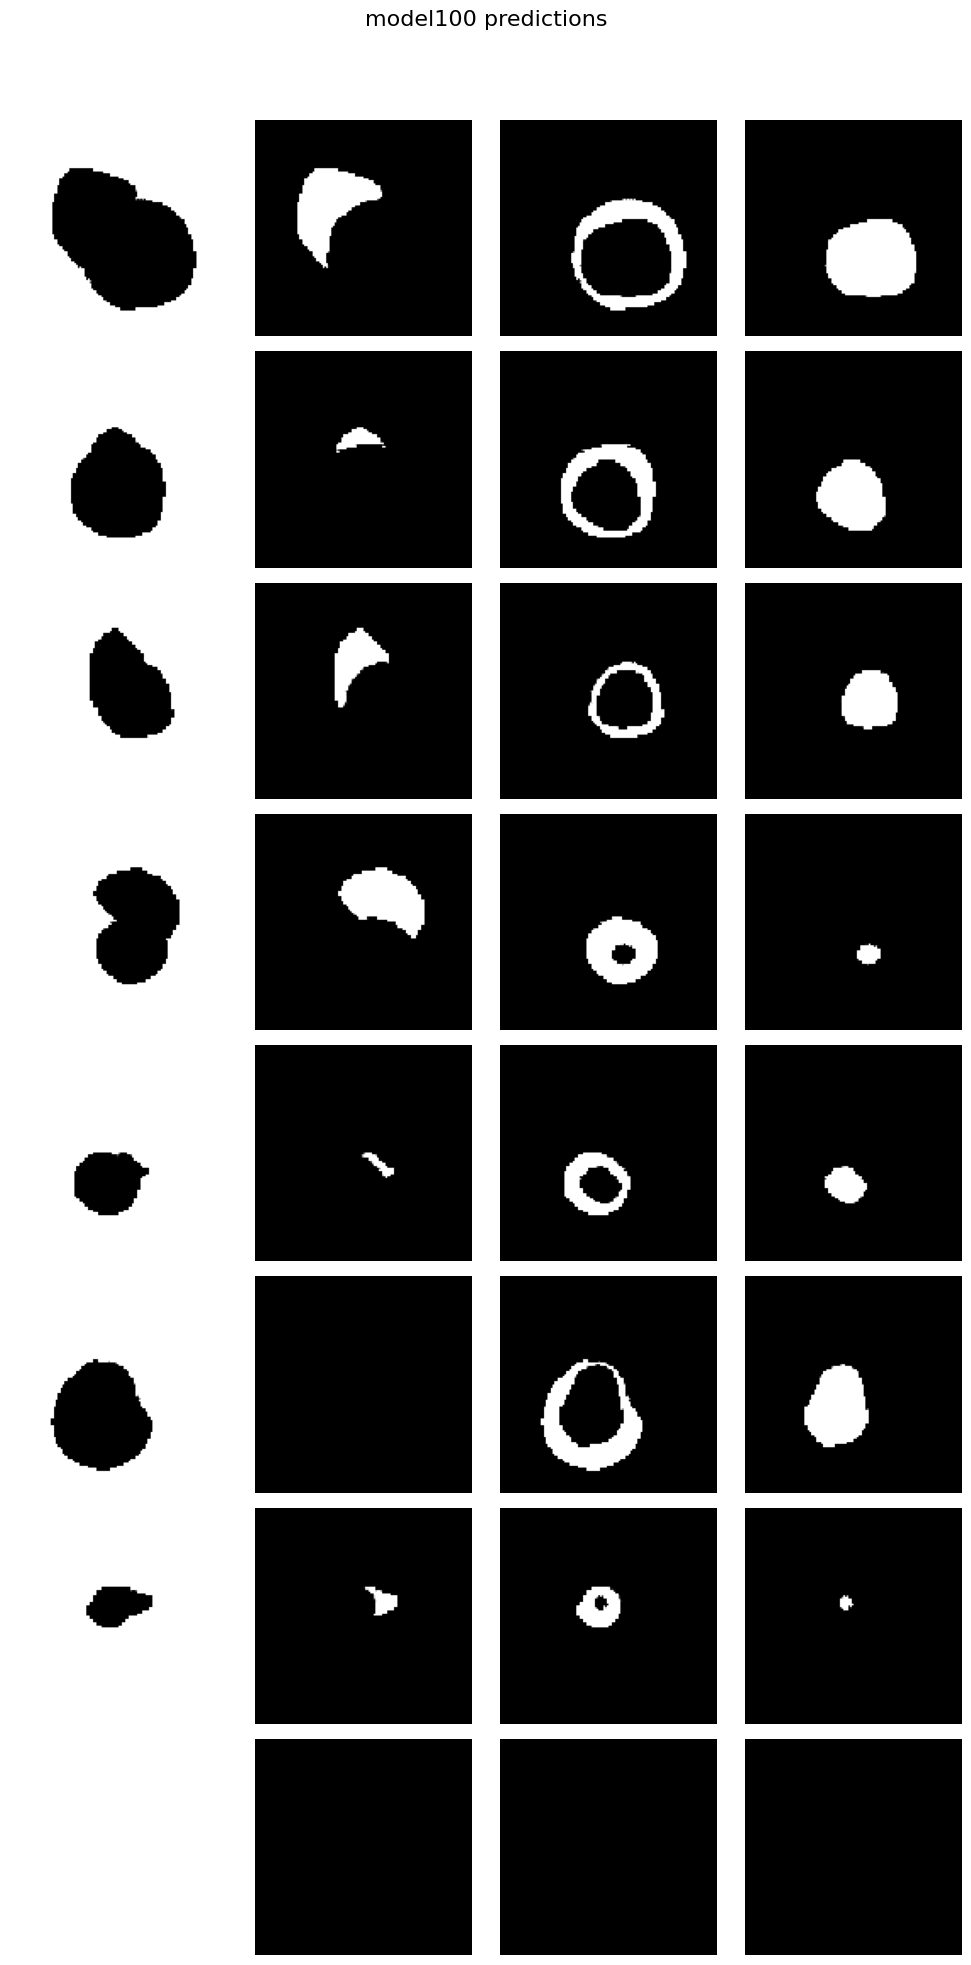

In [87]:
probs = F.softmax(batch_hat, dim=1) 
visualize_batch( probs.detach().cpu() , title= "model100 predictions")

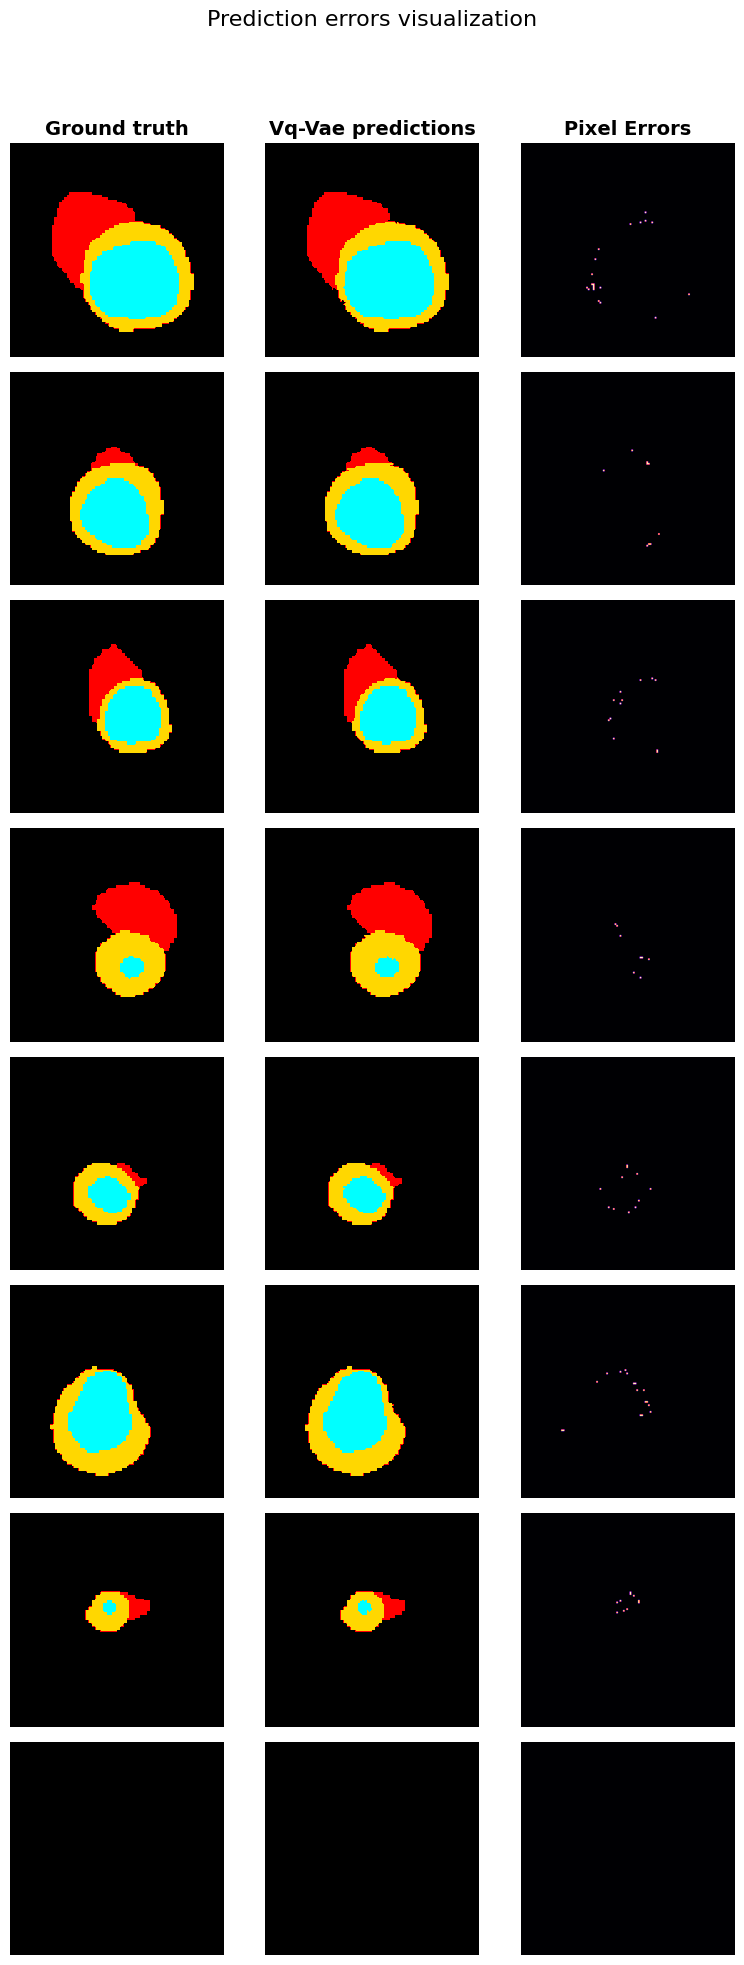

In [88]:

pred_seg = torch.argmax(probs,     dim=1).detach().cpu()
true_seg = torch.argmax(vis_batch, dim=1).detach().cpu()

visualize_erros(true_seg, pred_seg, 'Prediction errors visualization')